In [42]:
from IPython.display import Javascript, display
from ipywidgets import widgets

def run_all(event):
    display(Javascript('IPython.notebook.execute_cells_below()'))

button = widgets.Button(description='开始', button_style='info', tooltip='点击运行本项目', icon='check')
button.on_click(run_all)
display(button)

<IPython.core.display.Javascript object>

Button(button_style='info', description='开始', icon='check', style=ButtonStyle(), tooltip='点击运行本项目')

# <center>医学论文助手 - <b>M</b>edical <b>M</b>anuscript <b>Helper</b></center>

<b>说明</b>：仅适用于 <b>机器学习</b> - <b>监督学习</b> - <b>分类</b> 的医学论文

<b>操作</b>：点击 <b>菜单栏</b> - <b>Cell</b> - <b>Run All</b>，点击 <b>工具栏</b> - <b>眼睛</b> - <b>显示代码</b>

<b>注意</b>：查看结果需等待运行结束待机状态。右上角<b>Python 3</b>右侧圆圈 <b>空心</b> 待机状态， <b>实心</b> 正在运行。

## 前言

- 本项目范例数据集基于：[Breast Cancer Wisconsin (Diagnostic) Data Set](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data)
- 参考相关Kernels：[Feature Selection and Data Visualization](https://www.kaggle.com/kanncaa1/feature-selection-and-data-visualization) 和 [Intro to Keras with breast cancer data[ANN]](https://www.kaggle.com/thebrownviking20/intro-to-keras-with-breast-cancer-data-ann)

## 导入数据

<b>备注</b>：默认为当前目录下的data.xlsx文件，确认数据文件是否正确。

In [43]:
import pandas as pd
data = pd.read_excel('./data.xlsx')
print('共计：', data.shape[0],'行','，',data.shape[1],'列')
data.head()

共计： 495 行 ， 15 列


,tumor,age,history,menarche,menopause,gestation,abortion,pain,birads,ectasia,multiple,distance,size,margin,blood
0,0,47,0,13,0,3,1,1,0,0,1,0,1,1,0
1,0,47,0,13,0,3,1,1,0,0,1,0,0,1,0
2,0,44,1,14,0,2,1,0,0,0,1,0,0,1,0
3,0,44,1,14,0,2,1,0,0,0,1,0,1,1,0
4,0,44,1,14,0,4,3,0,0,0,1,0,1,0,0


## 评估可行性

### 查看相关性

<b>备注</b>：注意有无有预测值高度相关的特征，红色正相关，蓝色负相关。

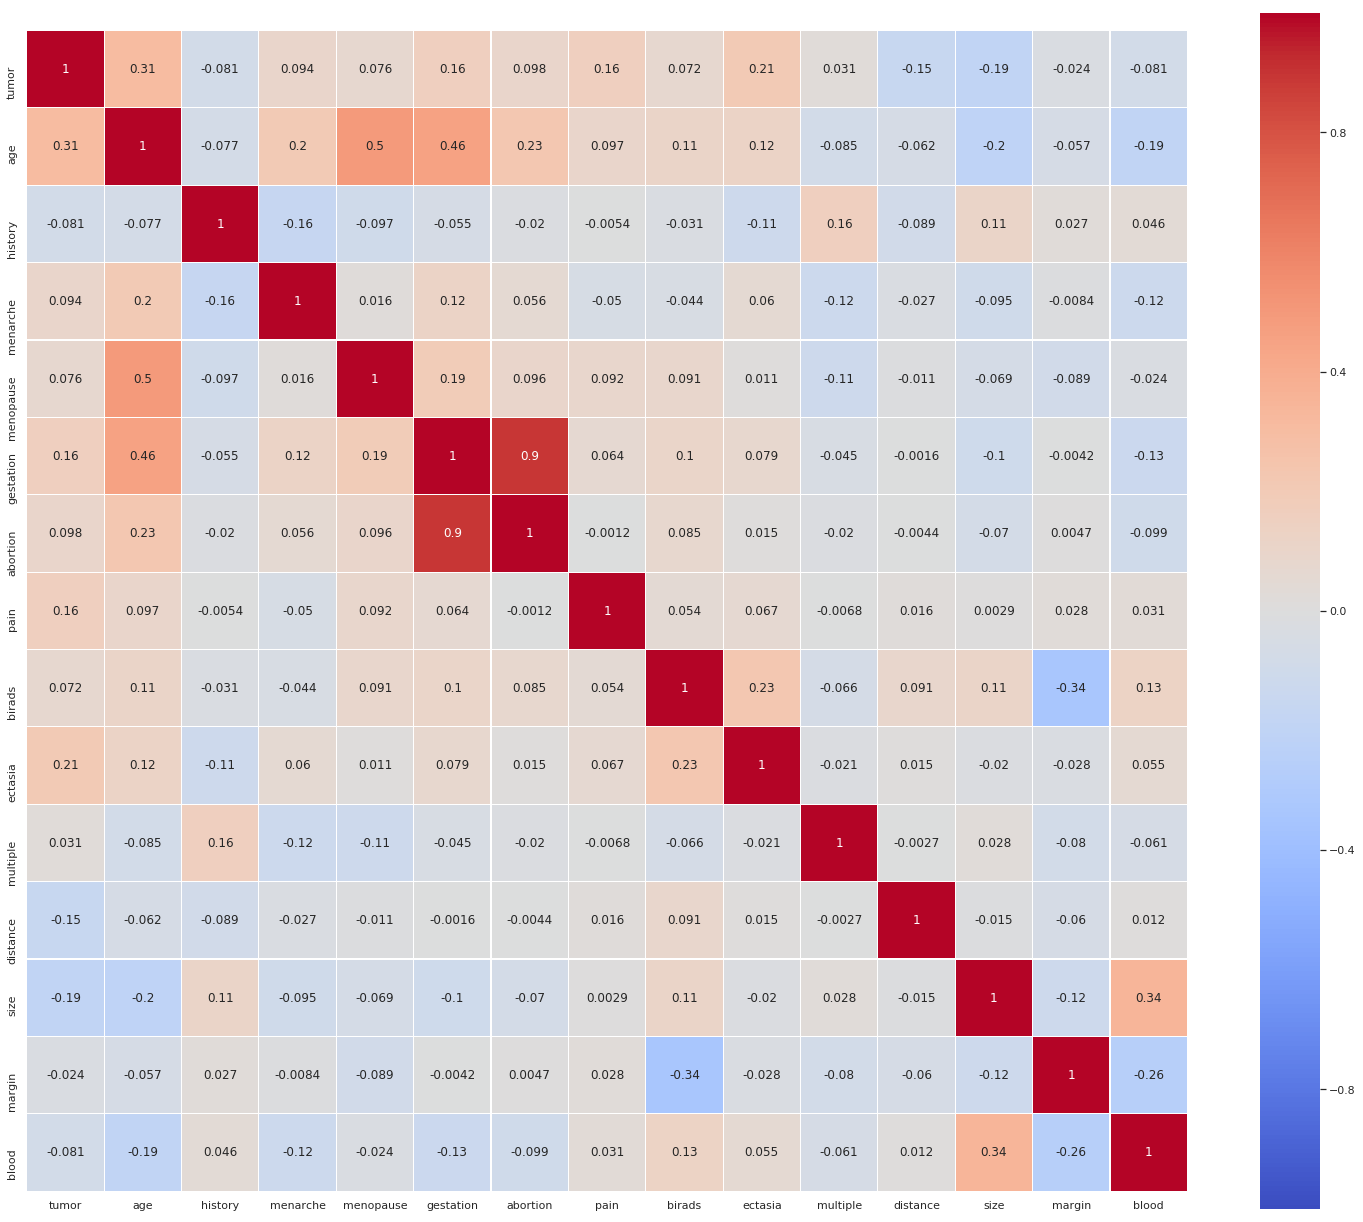

In [44]:
import numpy as np
import scipy.stats as scs

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

# view corr map

plt.figure(figsize=(26, 22))
sns.heatmap(data.astype(float).corr(),
            linewidths=0.1,
            square=True,
            cmap='coolwarm',
            linecolor='white',
            annot=True,
            vmax=1,
            vmin=-1);

### 查看预测准确度

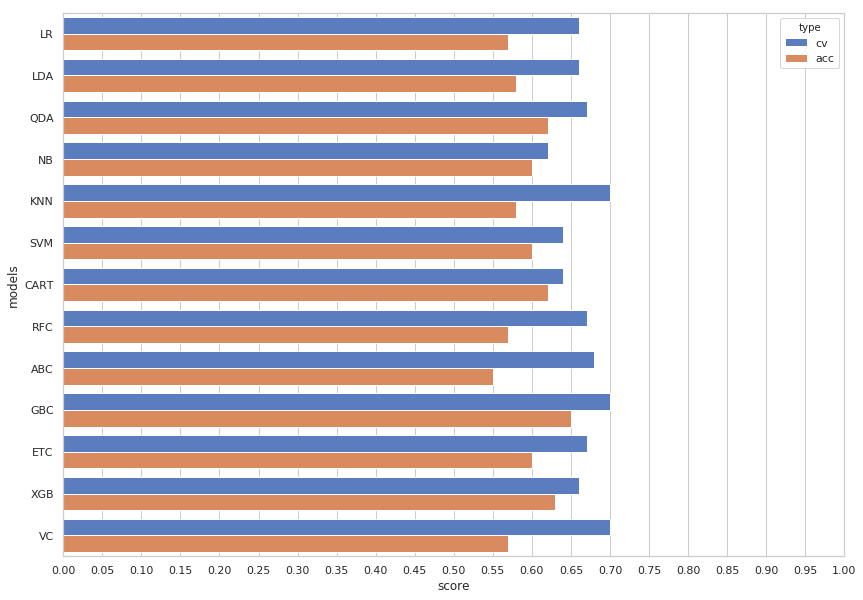

In [45]:
data = data.dropna()
X, y = data.values[:, 1:], data.values[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y)

models = {
    'LR': LogisticRegression(solver='liblinear', multi_class='auto'),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),
    'NB': GaussianNB(),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(gamma='scale'),
    'CART': DecisionTreeClassifier(),
    'RFC': RandomForestClassifier(n_estimators=100),
    'ABC': AdaBoostClassifier(),
    'GBC': GradientBoostingClassifier(),
    'ETC': ExtraTreesClassifier(n_estimators=100),
    'XGB': XGBClassifier(),
}

models['VC'] = VotingClassifier(estimators=[('lr', models['LR']), ('lda', models['LDA']), ('qda', models['QDA']),
                                            ('nb', models['NB']), ('knn', models['KNN']), ('svm', models['SVM']),
                                            ('cart', models['CART']), ('rfc', models['RFC']), ('abc', models['ABC']),
                                            ('gbc', models['GBC']), ('etc', models['ETC']), ('xgb', models['XGB'])], voting='hard')

kfold = StratifiedKFold(n_splits=10)
cv_result = []

for key in models:
        models[key].fit(X_train, y_train)
        cv_score = cross_val_score(
            models[key], X_train, y_train, scoring="accuracy", cv=kfold)
        cv_means = round(cv_score.mean(), 2)
    #     cv_std = round(cv_score.std(), 2)
        acc_score = round(models[key].score(X_test, y_test), 2)
        cvresult = {'models': key, 'score': cv_means, 'type': 'cv'}
        cv_result.append(cvresult)
        cvresult = {'models': key, 'score': acc_score, 'type': 'acc'}
        cv_result.append(cvresult)
    #     print(confusion_matrix(y_test, models[key].predict(X_test)))
    #     print(key)
    #     print('='*80)
    #     print(classification_report(y_test, models[key].predict(X_test)))

cv_results = pd.DataFrame(cv_result)

plt.figure(figsize=(14, 10))
sns.set(style="whitegrid")
g = sns.barplot(x='score', y='models', hue='type', data=cv_results, palette="muted");
# g = sns.barplot(x='score', y='models', hue='type', data=cv_results, **{'xerr': cv_std})
g.set_xticks(np.arange(0, 1.05, 0.05));


### 学习曲线

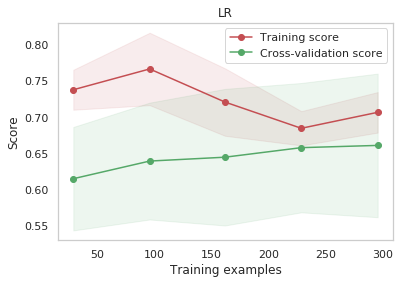

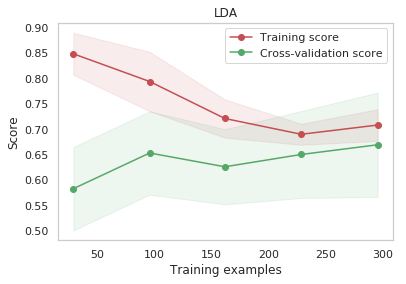

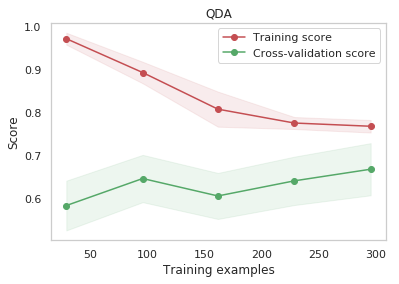

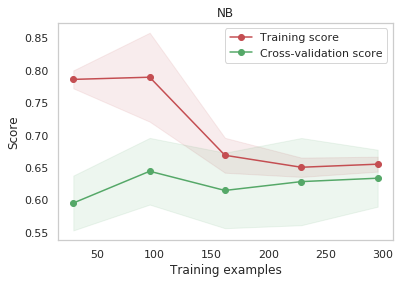

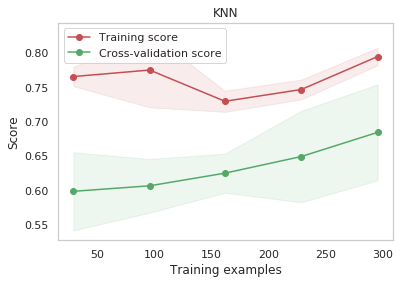

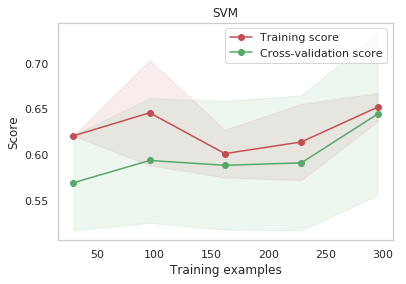

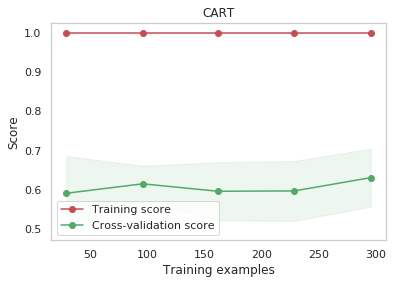

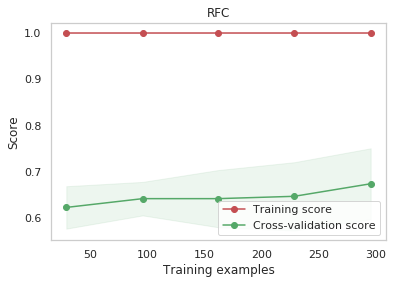

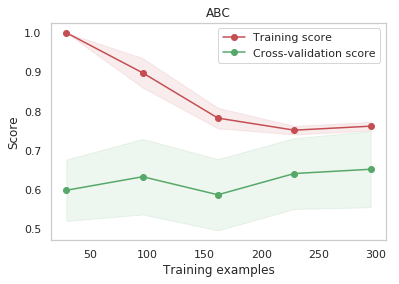

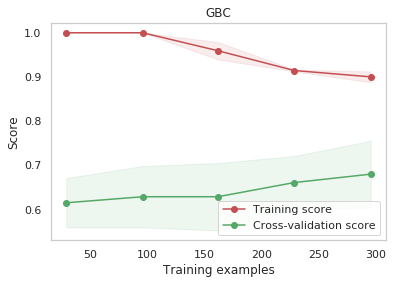

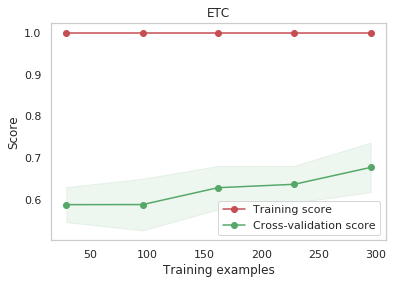

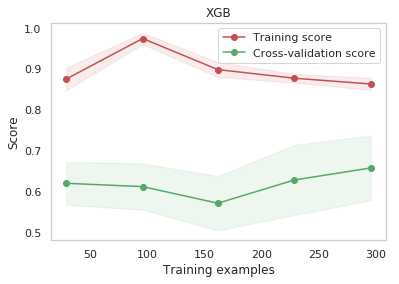

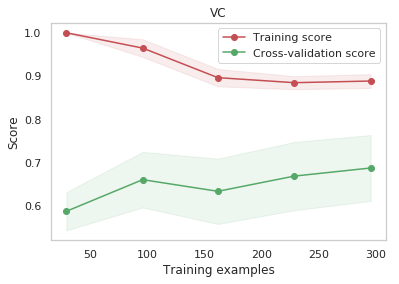

In [46]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,  color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-',
             color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-',
             color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt


for key in models:
    plot_learning_curve(models[key], key, X_train, y_train, cv=5)


## 提出问题

* 明确数据分析想解决或者了解的信息是什么？

## 理解数据

### 设定相关参数

In [47]:
# pd.set_option('precision', 2)  # 显示小数位数
# pd.set_option('max_rows', 11)  # 显示最大行数, describe需要11行
# pd.set_option('max_colwidth',40) # 最大列宽
# pd.reset_option('precision')  # 重置显示设置，其余选项类似
# %config InlineBackend.figure_format = 'svg'

### 数据基本信息

#### 查看数据基本结构

In [48]:
# dataframe.head()
# dataframe.head(), dataframe.tail(), dataframe.index, dataframe.columns, dataframe.values
# dataframe.T  # 行列互换
# dataframe.sort_values(by='age')  # 按列值排序
# dataframe[dataframe.age < 35]  # 按条件查看数据

In [49]:
# dataframe['distance'] = dataframe['distance'].fillna('1.0')
# dataframe['size'] = dataframe['size'].fillna('1.0')
# X_train = dataframe.drop('group', axis=1)
# y_train = dataframe['group']
# from sklearn.linear_model import LogisticRegression
# logreg = LogisticRegression()
# logreg.fit(X_train, y_train)
# acc_log = round(logreg.score(X_train, y_train) * 100, 2)
# logreg.coef_[0]

#### 设定数据类型

In [50]:
# dataframe[['group', 'menopause', 'gestation', 'pain', 'ectasia', 'multiple', 'distance', 'size']] = dataframe[[
#     'group', 'menopause', 'gestation', 'pain', 'ectasia', 'multiple', 'distance', 'size']].astype('category')
# category, int64, float64, datetime64, object
# dataframe.info()
# 确认数据结构

#### 数据基本统计信息

In [51]:
# dataframe.describe(include='all')

In [52]:
# dataframe.age.describe(percentiles=[.1, .2, .3, .4, .5, .6, .7, .8, .9, .99])

In [53]:
# dataframe.hist(grid=False, bins=20, figsize=(10,10), layout=(3,3));

---

#### 查看指定数据

In [54]:
# dataframe['group'].value_counts()
# dataframe.groupby('group').mean()
# dataframe[dataframe.age > 70]
# dataframe[['size','group']].groupby('size').mean()

* 数据相关性

In [55]:
# dataframe.corr(method='spearman')
# 'pearson', 'kendall', 'spearman'

* 分组情况（按第一列分组）

In [56]:
# chisq = data.groupby([data['group'], data['gestation']]).size()
# print(chisq)

In [57]:
# pd.crosstab(dataframe['group'], dataframe['gestation'], margins=True)

* 卡方检验（2*2表格）
    - 所有的理论数T≥5并且总样本量n≥40，用Pearson卡方进行检验。
    - 如果理论数T＜5但T≥1，并且1≥40，用连续性校正的卡方进行检验。
    - 如果有理论数T＜1或n＜40，则用Fisher’s检验。
    - 非2*2表格直接使用stats.chi2_contingency(chisq_matrix)

* R×C表卡方检验应用条件：
    - R×C表中理论数小于5的格子不能超过1／5；
    - 不能有小于1的理论数。如果实验中有不符合R×C表的卡方检验，可以通过增加样本数、列合并来实现。

In [58]:
# chisq_matrix = np.array([[chisq[0, 0], chisq[0, 1]],
#                          [chisq[1, 0], chisq[1, 1]]])
# stats.chi2_contingency(chisq_matrix, correction=False)  # Pearson
# stats.chi2_contingency(chisq_matrix) # 连续性校正
# stats.fisher_exact(chisq_matrix)

### 数据可视化

In [59]:
# g = sns.FacetGrid(dataframe, col='group')
# g.map(plt.hist, 'age',bins=20)

In [60]:
# grid = sns.FacetGrid(dataframe, col='group', row='menopause')
# grid.map(plt.hist, 'age', bins=20)
# grid.add_legend();

In [61]:
# grid = sns.FacetGrid(dataframe, row='menopause')
# grid.map(sns.pointplot, 'gestation', 'group', 'ectasia', palette='deep')
# grid.add_legend()

* 单变量密度图

In [62]:
# data.plot(
#     kind='density',
#     subplots=True,
#     figsize=(10, 10),
#     layout=(3, 3),
#     sharex=False)

* 单变量箱图

In [63]:
# data.plot(
#     kind='box', subplots=True, figsize=(10, 10), layout=(3, 3), sharex=False)

* 多变量相关矩阵图

In [64]:
# import numpy as np
# correlations = data.corr()
# fig = pyplot.figure()
# ax = fig.add_subplot('111')
# ax.matshow(correlations, vmin=-1, vmax=1)
# ticks = np.arange(0, 9, 1)
# ax.set_xticks(ticks)
# ax.set_yticks(ticks)
# ax.set_xticklabels(data.columns)
# ax.set_yticklabels(data.columns)
# fig.set_size_inches(10, 10)

* 散点矩阵图

In [65]:
# pd.plotting.scatter_matrix(data, figsize=(15,15));

### 数据预处理

* 数据缺失值处理

In [66]:
# data = dataframe.dropna()

* 分离数据

In [67]:
# from sklearn.model_selection import train_test_split
# array = data.values
# X = array[:, 1:]
# y = array[:, 0]

1. 调整尺度

In [68]:
# from sklearn.preprocessing import MinMaxScaler
# transformer = MinMaxScaler(feature_range=(0,1))
# X = transformer.fit_transform(X)

2. 正态化数据

In [69]:
# from sklearn.preprocessing import StandardScaler
# transformer = StandardScaler().fit(X)
# X = transformer.transform(X)

3. 标准化数据

In [70]:
# from sklearn.preprocessing import Normalizer
# transformer = Normalizer().fit(X)
# X = transformer.transform(X)

4. 二值数据

In [71]:
# from sklearn.preprocessing import Binarizer
# transformer = Binarizer().fit(X)
# X = transformer.transform(X)

### 特征选择

* 单变量特征选择

In [72]:
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import chi2
# testchi = chi2(X, Y)
# test = SelectKBest(score_func=chi2, k=2)
# fit = test.fit(X, Y)
# print(fit.scores_)
# features = fit.transform(X)
# test.get_support()

* 递归特征消除（RFE）

In [73]:
# from sklearn.feature_selection import RFE
# from sklearn.linear_model import LogisticRegression
# model = LogisticRegression(solver='lbfgs')
# rfe = RFE(model, 3)
# fit = rfe.fit(X, Y)
# print(fit.n_features_)
# print(fit.support_)
# print(fit.ranking_)

* 主要成分分析（PCA）

In [74]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=3)
# fit = pca.fit(X)
# print(fit.explained_variance_ratio_)
# print(fit.components_)

* 特征重要性

In [75]:
# from sklearn.ensemble import ExtraTreesClassifier
# model = ExtraTreesClassifier(n_estimators=100)
# fit = model.fit(X, Y)
# print(fit.feature_importances_)

### 评估算法

* 数据分组

In [76]:
# testsize = 0.2
# seed = 4
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=testsize, random_state=seed)

* 评估模型

In [77]:
# from sklearn.model_selection import KFold
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import classification_report
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import accuracy_score

# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.svm import SVC

# from xgboost import XGBClassifier

# models = {}
# models['LR'] = LogisticRegression(solver='liblinear')
# models['LDA'] = LinearDiscriminantAnalysis()
# models['KNN'] = KNeighborsClassifier()
# models['CART'] = DecisionTreeClassifier()
# models['NB'] = GaussianNB()
# models['SVM'] = SVC(gamma='scale')
# models['XGB'] = XGBClassifier()

# results = []
# for key in models:
#     kfold = KFold(n_splits=10, random_state=seed)
#     cv_results = cross_val_score(
#         models[key], X_train, y_train, cv=kfold, scoring='accuracy')
#     results.append(cv_results)


* 箱图比较算法

In [78]:
# plt.boxplot(results);

### 预测

In [79]:
# svm = SVC(gamma='scale')
# svm.fit(X=X_train, y=y_train)
# predictions = svm.predict(X_test)
# models['XGB'].fit(X_train, y_train)
# predictions = models['XGB'].predict(X_test)

In [80]:
# accuracy_score(y_test, predictions)

In [81]:
# confusion_matrix(y_test, predictions)

In [82]:
# print(classification_report(y_test, predictions))